<a href="https://colab.research.google.com/github/AnIsAsPe/ClassificadorCancerEsofago/blob/master/Notebooks/PerceptronClasificadorCancerEs%C3%B3fago.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2> Clasificador de tejido sano y tejido cancerígeno en imágenes microscópicas del esófago

![image.png](https://drive.google.com/uc?id=1K_j4CnOJeOmiROBiFwEW1M-kJkizrMk7)

## Paso 1. Cargar librerías y módulos requerdidos

In [1]:
import random        # Módulo para aleatorizar.
import pickle        # Módulo para respaldar objetos de pyhton como cadenas de bytes
                     # (serialización de objetos).

import numpy as np   # Biblioteca para manejar matrices y operaciones de matrices
import pandas as pd  # Biblioteca para manejar tablas de datos.

# Funciones de la biblioteca Scikit-image para leer y mostrar una una imagen.
from skimage.io import imshow, imread

# Sklearn (Scikit-learn) es la  principal biblioteca para machine learning.
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron

# Bibliotecas para gráficar y visualizar.
import matplotlib.pyplot as plt
import seaborn as sns

## Paso 2. Lectura de datos.

### 2.1 Lectura de etiquetas (y)

In [2]:
# Leemos los datos.

datos = pd.read_csv("https://raw.githubusercontent.com/AnIsAsPe/ClassificadorCancerEsofago/master/Datos/ClasesImagenes.csv", usecols=[1,2])


In [3]:
type(datos)

pandas.core.frame.DataFrame

In [4]:
 # Muestra los primeros cinco registros.
datos.head()

,image_filename,class_number
0,im_4_0.png,0
1,im_21_0.png,0
2,im_9_0.png,0
3,im_8_0.png,0
4,im_15_0.png,0


In [5]:
# ¿Con cuántas imagenes vamos a trabajar?

datos.shape[0]

5063

In [6]:
# ¿cuántas imagenes tenemos de cada clase?

datos['class_number'].value_counts(sort=False)

,count
class_number,
0,1469
1,3594


Clase 0 corresponde a tejido sano y Clase 1 a tejido Cancerígeno

In [7]:
# Guardamos las etiquetas de las imagenes como Series de Pandas.
y = datos['class_number']


### 2.2 Lectura de imágenes (X)

**Lo primero que tenemos que hacer es descomprimir el archivo zip que guardamos en nuestro dirve**

In [10]:

!unzip -u "/content/drive/MyDrive/Datos/DatosCancer/imagenes_260x260.zip" -d "/content/drive/MyDrive/Datos/DatosCancer/Unzip260x260/"


Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: /content/drive/MyDrive/Datos/DatosCancer/Unzip260x260/im_102_3.png  
  inflating: /content/drive/MyDrive/Datos/DatosCancer/Unzip260x260/im_102_31.png  
  inflating: /content/drive/MyDrive/Datos/DatosCancer/Unzip260x260/im_102_34.png  
  inflating: /content/drive/MyDrive/Datos/DatosCancer/Unzip260x260/im_102_36.png  
  inflating: /content/drive/MyDrive/Datos/DatosCancer/Unzip260x260/im_102_4.png  
  inflating: /content/drive/MyDrive/Datos/DatosCancer/Unzip260x260/im_102_40.png  
  inflating: /content/drive/MyDrive/Datos/DatosCancer/Unzip260x260/im_102_42.png  
  inflating: /content/drive/MyDrive/Datos/DatosCancer/Unzip260x260/im_102_44.png  
  inflating: /content/drive/MyDrive/Datos/DatosCancer/Unzip260x260/im_102_49.png  
  inflating: /content/drive/MyDrive/Datos/DatosCancer/Unzip260x260/im_102_50.png  
  inflating: /content/drive/MyDrive/Datos/DatosCancer/Unzip260x260/im_102_53.png  
  inflating: /content/

In [11]:
datos['image_filename'].head()

,image_filename
0,im_4_0.png
1,im_21_0.png
2,im_9_0.png
3,im_8_0.png
4,im_15_0.png


**Vamos a leer la primera imagen, para ello además del nombre de la imagen, necesitamos añadir la ruta del directorio en donde se encuentra dicha imagen.**

In [18]:
nombre_archivo = 'im_4_0.png'

ruta = '/content/drive/MyDrive/Datos/DatosCancer/Unzip260x260/'

imagen = imread(ruta  + nombre_archivo)

In [19]:
# ¿Qué tipo de objeto es imagen?
type(imagen)

numpy.ndarray

In [20]:
# ¿Qué dimensiones tiene imagen?
imagen.shape

(260, 260)

In [21]:
# Exploramos el nivel de coloración de algunos de los pixeles de la imagen
imagen[72:80, 170:190]

array([[57, 58, 59, 60, 61, 61, 61, 62, 63, 65, 66, 67, 67, 69, 73, 74,
        75, 77, 77, 76],
       [51, 52, 53, 54, 54, 55, 56, 57, 58, 59, 59, 60, 60, 62, 65, 67,
        69, 70, 69, 68],
       [47, 47, 48, 50, 51, 52, 53, 53, 54, 53, 54, 55, 56, 57, 58, 60,
        62, 64, 64, 63],
       [45, 45, 45, 46, 48, 50, 50, 50, 50, 50, 50, 51, 52, 52, 53, 55,
        58, 60, 62, 60],
       [44, 44, 44, 44, 45, 47, 47, 47, 47, 46, 47, 47, 48, 49, 50, 52,
        54, 57, 60, 60],
       [43, 43, 43, 43, 44, 45, 45, 45, 45, 45, 45, 46, 46, 48, 50, 52,
        53, 55, 59, 58],
       [41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 43, 43, 44, 45, 47, 49,
        51, 53, 55, 54],
       [40, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 40, 40, 41, 42, 44,
        46, 48, 52, 51]], dtype=uint8)

<ipython-input-22-f55e9287f745>:1: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(imagen)


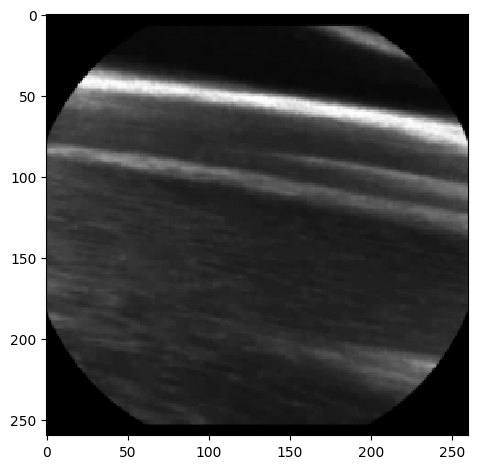

In [22]:
imshow(imagen)

**Ahora vamos a hacer lo mismo para todas las imagenes**

In [23]:
datos['image_filename']

,image_filename
0,im_4_0.png
1,im_21_0.png
2,im_9_0.png
3,im_8_0.png
4,im_15_0.png
...,...
5058,im_114_55.png
5059,im_7_55.png
5060,im_52_55.png
5061,im_10_55.png


In [24]:
%time  img = datos['image_filename'].apply(lambda x: imread(ruta + x, as_gray=True))

CPU times: user 15.9 s, sys: 2.43 s, total: 18.3 s
Wall time: 41.1 s


<h2>Respaldamos el objeto img en un archivo pickle.<h2>

(si quieres conocer más sobre pickles de python, revisa [este enlace](https://programacion.net/articulo/los_pickles_de_python_1860))

In [25]:
# Guardar en archivo pickle
ruta2 = '/content/drive/MyDrive/Datos/DatosCancer/' # directorio donde se guardará el
pickle.dump(img, open (ruta2 + "imagenes_numpy.pkl", 'wb'))

In [ ]:
# Leer archivo pickle
ruta2 = '/content/drive/MyDrive/Datos/DatosCancer/'
img = pickle.load(open(ruta2 + "imagenes_numpy.pkl", 'rb'))

In [29]:
img[47].shape

(260, 260)

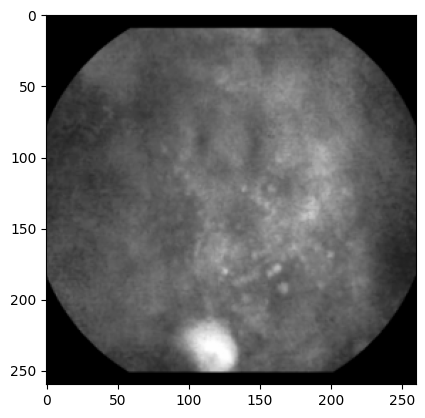

In [38]:
_ = plt.imshow(img[47],  cmap='Greys_r')

- Dimensión 0: 260 renglones de pixeles de arriba a abajo
- Dimensión 1: 260 columnas de pixeles de izquierda a derecha


####  Transformar imágenes en vectores

In [32]:
# Una serie de pandas es también una secuencia (como lo son las listas,
# las tuplas, las cadenas de caracteres o los vectores de numpy).

type(img)

pandas.core.series.Series

In [33]:
# Cantidad de elementos en la serie
img.shape

(5063,)

In [34]:
# Cada elemento de mi secuencia es una matriz de 260 x 260
img[3673].shape

(260, 260)

Lo primero es transformar la secuencia de matrices img en una sola matriz

In [35]:
IMG = np.stack(img, axis=0)   # Toma una secuencia de matrices y las apila a lo largo
                              # de un tercer eje para hacer una solo arreglo
IMG.shape

(5063, 260, 260)

Despues aplanar la matriz de 2D (260x260 pixeles) de cada imagen, para obtener un vector por imagen.

In [36]:
X = IMG.reshape(5063, 67600)
X.shape

(5063, 67600)

##### Visualizamos ejemplos de ambas clases de imagenes

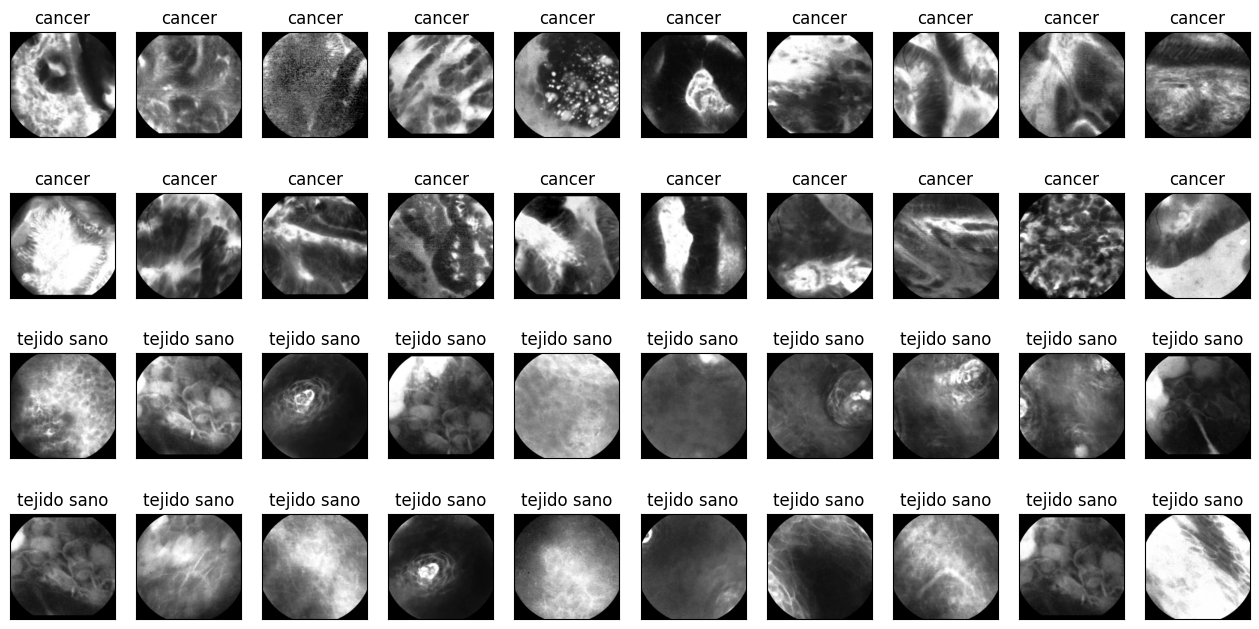

In [37]:
# Con el método GroupBy de Pandas separamos el data frame en dos, de acuerdo
# la nuestra etiqueta.
porClase = datos.groupby('class_number')

# Elijimos al azar n muestras de cada subconjunto y guardamos la posición de las
# imagenes cancerigenas en la lista "c" y en  "s" las de tejido sano.
n = 20
c = random.sample(porClase.get_group(1).index.tolist(), n)
s = random.sample(porClase.get_group(0).index.tolist(), n)


# Creamos el espacio para las 40 imagenes que vamos a desplegar
fig = plt.figure(figsize=(16, 8))
columns = 10
rows = 4

# Desplegamos las imagenes
for i in range(0, 40):
    fig.add_subplot( rows, columns, i+1)
    if i < 20:
        plt.imshow(img[c[i]], cmap='Greys_r')
        plt.title('cancer')
        plt.xticks([])
        plt.yticks([])
    else:
        plt.imshow(img[s[i-20]], cmap='Greys_r')
        plt.title('tejido sano')
        plt.xticks([])
        plt.yticks([])
plt.show()

## Paso 3. Construcción de nuestro clasificador

### 3.1  Crear subconjuntos de entrenamiento y prueba



In [39]:
X_train, X_test, y_train, y_test = train_test_split( X, y,
                                                    test_size=0.3,
                                                    shuffle=True,
                                                    random_state=0)

In [40]:
# ¿Cómo son los conjuntos de entrenamiento y prueba?
print("Training set")
print("X: ", X_train.shape)
print("y: ", y_train.shape)
unique, counts = np.unique(y_train, return_counts=True)
print('Tejido Sano:        ', counts[0],'\nDisplasia o Cáncer: ', counts[1],'\n')


print("Test set")
print("X: ", X_test.shape)
print("y: ", y_test.shape)
unique, counts = np.unique(y_test, return_counts=True)
print('Tejido Sano:         ', counts[0],'\nDisplasia o Cáncer: ', counts[1],'\n')

Training set
X:  (3544, 67600)
y:  (3544,)
Tejido Sano:         1043 
Displasia o Cáncer:  2501 

Test set
X:  (1519, 67600)
y:  (1519,)
Tejido Sano:          426 
Displasia o Cáncer:  1093 



### 3.2  Entrenamiento



In [41]:
model = Perceptron(max_iter=1000, random_state=0, verbose=False)
model.fit(X_train, y_train)

print("Iterations: ", model.n_iter_)

Iterations:  58


In [42]:
# Guardamos los coeficientes del modelo
betas = model.coef_
betas.shape

(1, 67600)

In [43]:
beta0 = model.intercept_
beta0

array([-508.])

In [44]:
betas[0, 50310:50320]

array([-2993.,  5868., 12611., 16160., 10978.,  7229.,  2143., -2380.,
       -3507.,  -883.])

### 3.3 Pedicción

In [45]:
y_predict = model.predict(X_test)  # Clasifica cada imagen de X_test
y_predict[:20]

array([0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0])

### 3.4 Evaluación

In [46]:
y_test.to_numpy()[:20]

array([0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1])

In [47]:
print("Exactitud conjunto entrenamiento: %.2f%%" % (model.score(X_train, y_train)*100.0))
print("Exactitud conjunto prueba: %.2f%%" % (model.score(X_test, y_test)*100.0))

Exactitud conjunto entrenamiento: 98.70%
Exactitud conjunto prueba: 91.71%


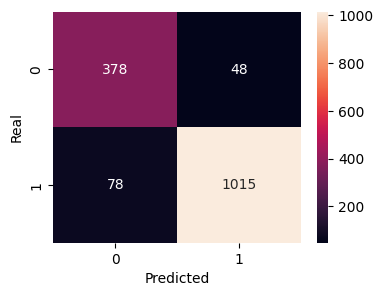

In [67]:
def matriz_confusion(y_test, y_predict):
    df = pd.DataFrame({
        'Real': y_test,
        'Predicted': y_predict
    })
    # Matriz de confusión
    confusion_matrix = pd.crosstab(df['Real'],df['Predicted']
                               )
    fig, ax = plt.subplots(figsize=(4, 3))  # Tamaño de la figura
    _ = sns.heatmap(confusion_matrix, annot=True, fmt='g',  ax=ax)

matriz_confusion(y_test, y_predict)

## Paso 4. Entrenamiento de perceptron utilizando margen

In [59]:
model_2 = Perceptron(max_iter=1000,  random_state=0, verbose=False,
                    penalty='l2', alpha=5e-8)
model_2.fit(X_train,y_train)

print("Exactitud conjunto entrenamiento: %.2f%%" % (model_2.score(  X_train, y_train)*100.0))
print("Exactitud conjunto prueba: %.2f%%" % (model_2.score(X_test, y_test)*100.0))

Exactitud conjunto entrenamiento: 99.44%
Exactitud conjunto prueba: 92.89%


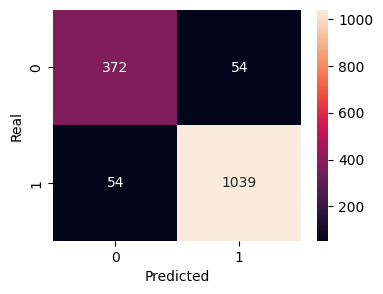

In [68]:
y_predict_2 = model_2.predict(X_test)
matriz_confusion(y_test, y_predict_2)